# 0. Meta

## 0.1. Packages

In [60]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.cm import viridis


## 0.2. Functions

Function for creating a grid of scatter plots to visualize the relationships between variables after applying different transformations. This function allows users to specify variables for the x-axis and y-axis and plot both the original and transformed variables in a grid. Each subplot shows a scatterplot with annotations indicating the type of transformation applied to each variable. The primary goal of this function is to help identify transformations required to establish linearity between the target and the features.

In [180]:
def transformation_scatterplot_grid(data, variable_x, variable_y):
    """
    Create a grid of scatter plots to visualize relationships between variables with different transformations i.e. log1p, cbrt, sqrt, square, cube.

    Parameters:
        data (DataFrame): The DataFrame containing the data.
        variable_x (str): The name of the variable to be plotted on the x-axis.
        variable_y (str): The name of the variable to be plotted on the y-axis.

    Returns:
        None
    """
    # List of transformations
    transformations = ['original', 'log1p', 'cbrt', 'sqrt', 'square', 'cube']
    transformation_labels = ['original', 'log1p', 'cbrt', 'sqrt', 'square', 'cube']

    # Create subplots
    fig, axes = plt.subplots(ncols=len(transformations), nrows=len(transformations), figsize=(24, 24))

    for i, transformation_x in enumerate(transformations):
        for j, transformation_y in enumerate(transformations):
            # Prepare data based on transformation
            data_x = data[variable_x]
            data_y = data[variable_y]

            if transformation_x == 'log1p':
                data_x = np.log1p(data_x)
            elif transformation_x == 'cbrt':
                data_x = np.cbrt(data_x)
            elif transformation_x == 'sqrt':
                data_x = np.sqrt(data_x)
            elif transformation_x == 'square':
                data_x = data_x**2
            elif transformation_x == 'cube':
                data_x = data_x**3

            if transformation_y == 'log1p':
                data_y = np.log1p(data_y)

            # Create scatter plot
            sns.scatterplot(x=data_x, y=data_y, ax=axes[i, j], alpha=0.1)
            axes[i, j].set_title(f'{transformation_labels[j]} {variable_y} vs {transformation_labels[i]} {variable_x}', fontweight='bold')
            axes[i, j].set_xlabel(f'{transformation_labels[i]} {variable_x}')
            axes[i, j].set_ylabel(f'{transformation_labels[j]} {variable_y}')


# 1. Data import

The data originates from Kaggle, specifically the dataset titled ["Cars Germany"](https://www.kaggle.com/datasets/ander289386/cars-germany/data). Spanning from 2011 to 2021, the dataset encompasses information sourced from AutoScout24, one of Europe's major car markets for new and used vehicles. The data collection and scraping were facilitated by an automated tool developed at ZenRows, capturing essential details such as make, model, mileage, horsepower, and more.

In [61]:
df_raw = pd.read_csv("../data/raw/autoscout24.csv")

# 2. Initial Data exploration

## 2.1. Structure of Data

Shape and dimensions of raw data.

In [62]:
print(f"Shape of data: {df_raw.shape}")
print(f"Dimensionality of data: {df_raw.shape[0]/df_raw.shape[1]}")

Shape of data: (46405, 9)
Dimensionality of data: 5156.111111111111


Dimensionality: very low (n/p ~  5156).

## 2.2. Scale of Measure

Check for correct assignment of scales.

In [63]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46405 entries, 0 to 46404
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mileage    46405 non-null  int64  
 1   make       46405 non-null  object 
 2   model      46262 non-null  object 
 3   fuel       46405 non-null  object 
 4   gear       46223 non-null  object 
 5   offerType  46405 non-null  object 
 6   price      46405 non-null  int64  
 7   hp         46376 non-null  float64
 8   year       46405 non-null  int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 3.2+ MB


Scales are correctly assigned. However, "offerType" could be of scale "ordinal".Check unique levels of "offerType".

In [64]:
df_raw["offerType"].unique()

array(['Used', 'Demonstration', "Employee's car", 'Pre-registered', 'New'],
      dtype=object)

The variable "offerType" represent an ordinal variable, as there is an implicit ranking order:

'Used'  < "Employee's car" < 'Demonstration' < 'Pre-registered' < 'New'

## 2.2. Missing Entries

Total number and proportion of missing entries.

In [65]:
total_rows_with_missing_values = df_raw.isnull().any(axis=1).sum()
print(f"Total number of rows with at least one missing entry: {total_rows_with_missing_values}")
print(f"Proportion of rows with at least one missing entry: {round(total_rows_with_missing_values/df_raw.shape[0]*100,2)}%")

Total number of rows with at least one missing entry: 334
Proportion of rows with at least one missing entry: 0.72%


Only very little amount of rows contain missing entries. 

Visualize missing values for each column with heatmap and bar charts.

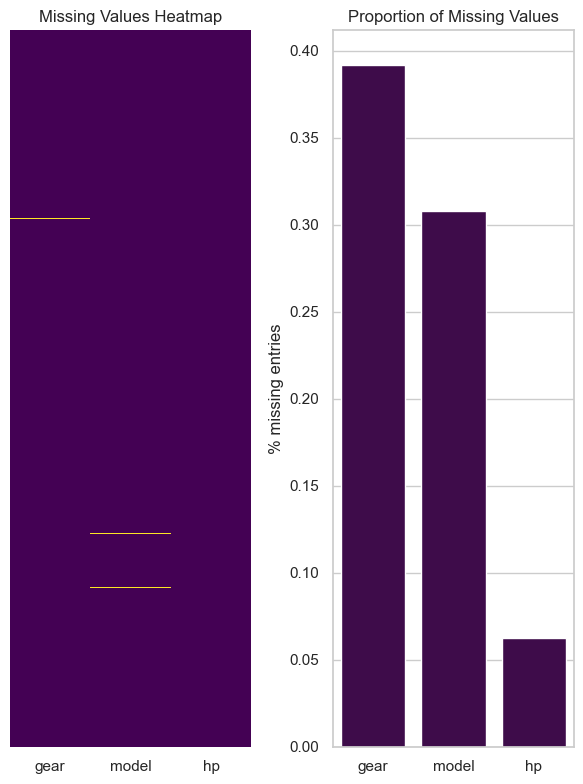

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(6, 8))

sns.heatmap(
    df_raw[df_raw.isnull().sum().sort_values(ascending=False).index]
        .loc[:, df_raw.isnull().sum().sort_values(ascending=False) > 0]
        .isnull(),
    cbar=False, cmap='viridis',
    yticklabels=False,
    ax=axes[0]  
)
axes[0].set_title('Missing Values Heatmap')


sns.barplot(
    x=df_raw.isnull().sum()[df_raw.isnull().sum() > 0].sort_values(ascending=False).index,
    y=(100*df_raw.isnull().sum()[df_raw.isnull().sum() > 0]/df_raw.shape[0]).sort_values(ascending=False),
    color=viridis(0),
    ax=axes[1]  
)
axes[1].set_title('Proportion of Missing Values')
axes[1].set_xlabel('')
axes[1].set_ylabel('% missing entries')

plt.savefig('../reports/figures/missing_entries.png')
plt.tight_layout()  
plt.show()

## 2.3. Categorial Variables

### 2.3.1. Counts per categorical level

Visualize the number of sales across the levels of each categorical variable. First create count data for plotting.

In [67]:
# Filter non-numeric columns
non_numeric_columns = df_raw.select_dtypes(exclude=['number']).columns

# Initialize an empty list to store DataFrames
dfs = []

# Iterate over non-numeric columns
for column in non_numeric_columns:
    # Count the occurrences of each level
    counts = df_raw[column].value_counts().reset_index()
    # Rename columns for consistency
    counts.columns = ['Level', 'Count']
    # Add a new column for the variable name
    counts['Variable'] = column
    # Append the counts DataFrame to the list
    dfs.append(counts)

# Concatenate all DataFrames in the list
counts_df = pd.concat(dfs, ignore_index=True)

Plot number of sales by car makes.

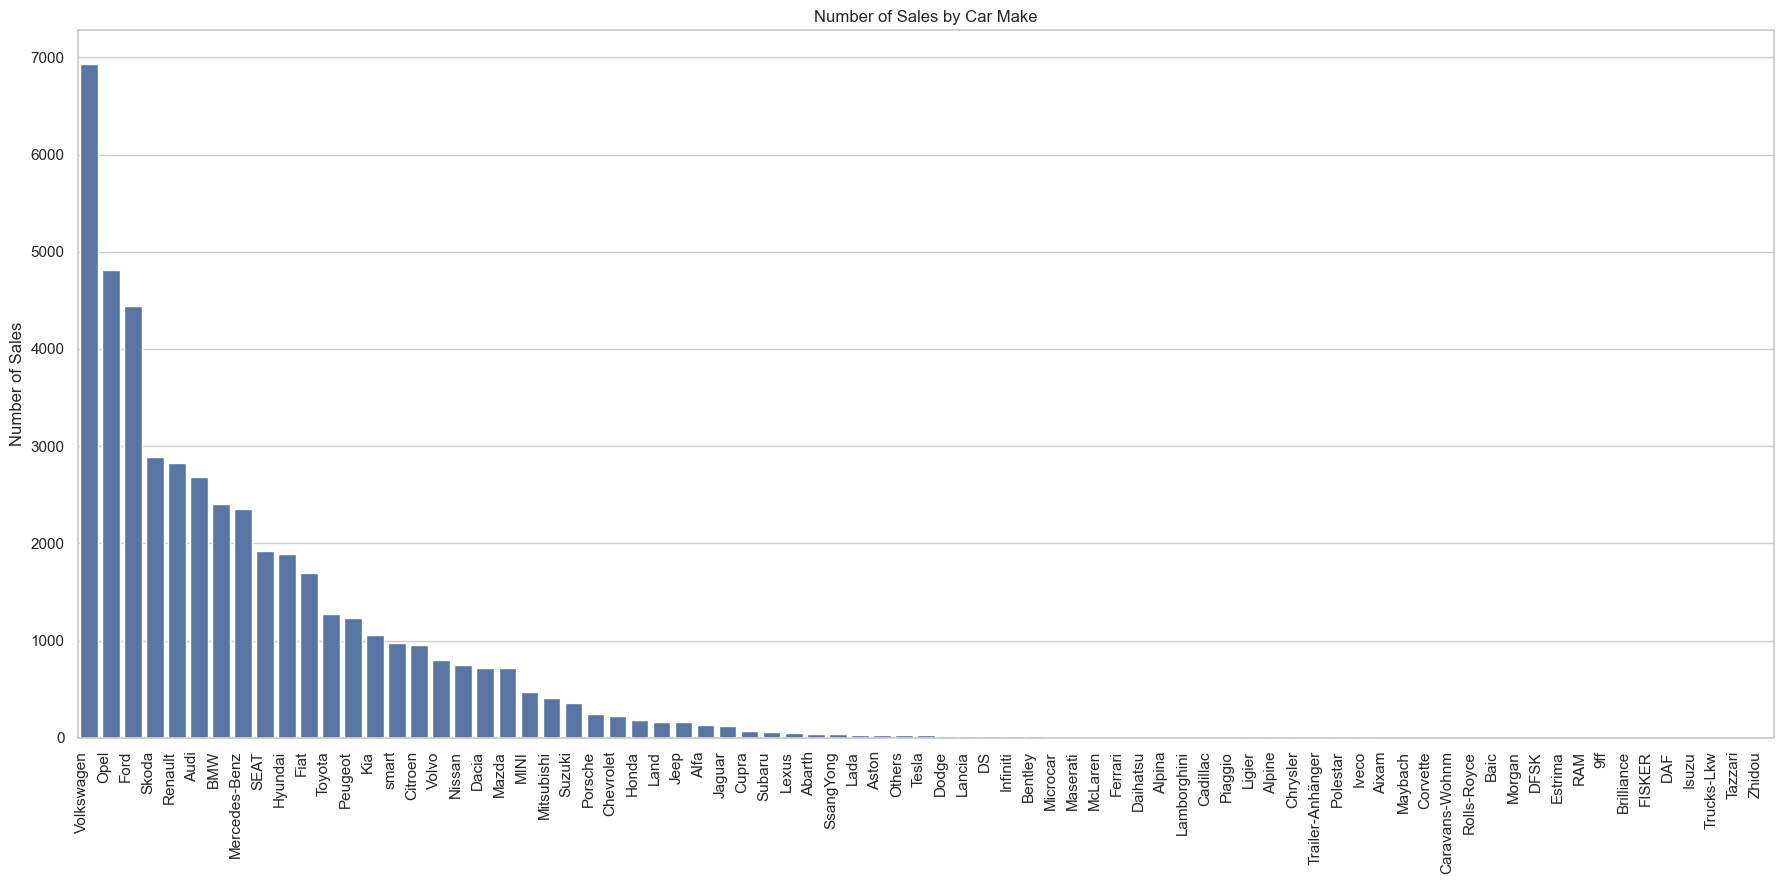

In [70]:
# Set the style for seaborn
sns.set_theme(style="whitegrid")

# Set up the matplotlib figure for each variable
plt.figure(figsize=(18, 9))

# Create a barplot for the current variable
sns.barplot(x='Level', y='Count', data=counts_df[counts_df['Variable'] == 'make'])
# Customize the plot
plt.title(f'Number of Sales by Car Make')
plt.xlabel('')
plt.ylabel('Number of Sales')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, ha='right')

# Show the plot for the current variable
plt.savefig('../reports/figures/sales_by_make.png')
plt.tight_layout()
plt.show()

The majority of sales are attributed to the first 20 to 30 car makes, while all other brands hold a relatively insignificant share in terms of sales volume.

Plot number of sales by car models.

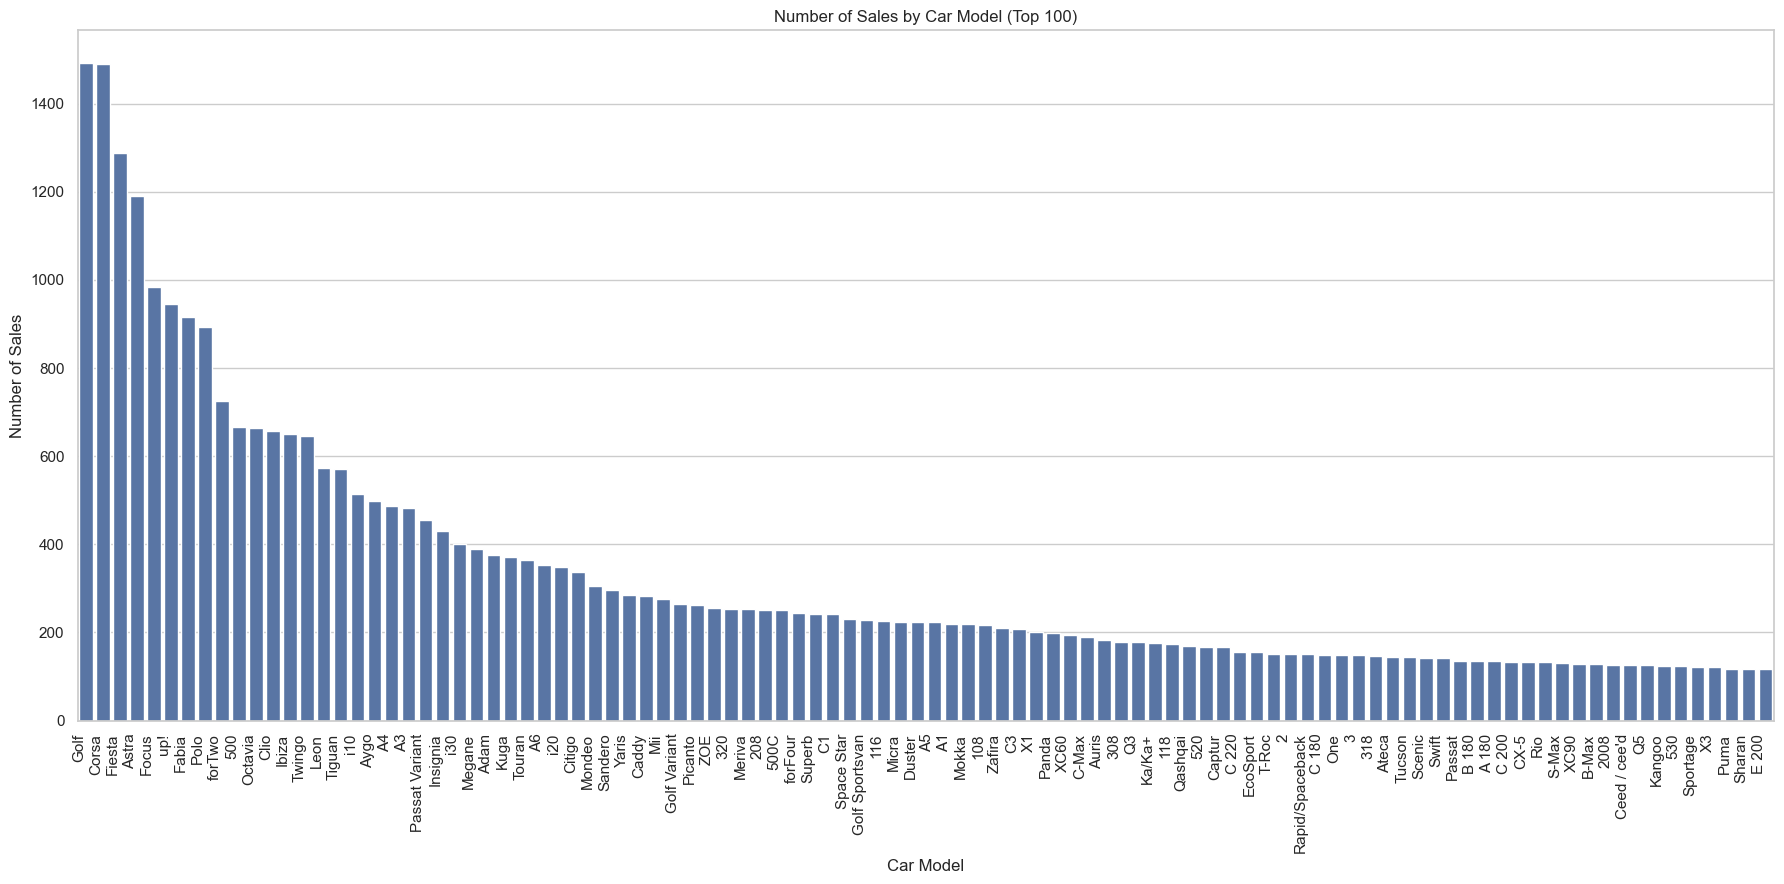

In [71]:
# Filter data for the 'model' variable
model_data = counts_df[counts_df['Variable'] == 'model']

# Sort the models by count in descending order
top_models = model_data.sort_values(by='Count', ascending=False).head(100)

# Set up the matplotlib figure for each variable
plt.figure(figsize=(18, 9))

# Create a barplot for the top models
sns.barplot(x='Level', y='Count', data=top_models)
# Customize the plot
plt.title(f'Number of Sales by Car Model (Top 100)')
plt.xlabel('Car Model')
plt.ylabel('Number of Sales')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, ha='right')

# Show the plot for the top models
plt.savefig('../reports/figures/sales_by_model.png')
plt.tight_layout()
plt.show()

The sales show a rapid decline over the the top 50 models, with a much slower decline for the following 50 models.

Plot number of sales by fuel type.

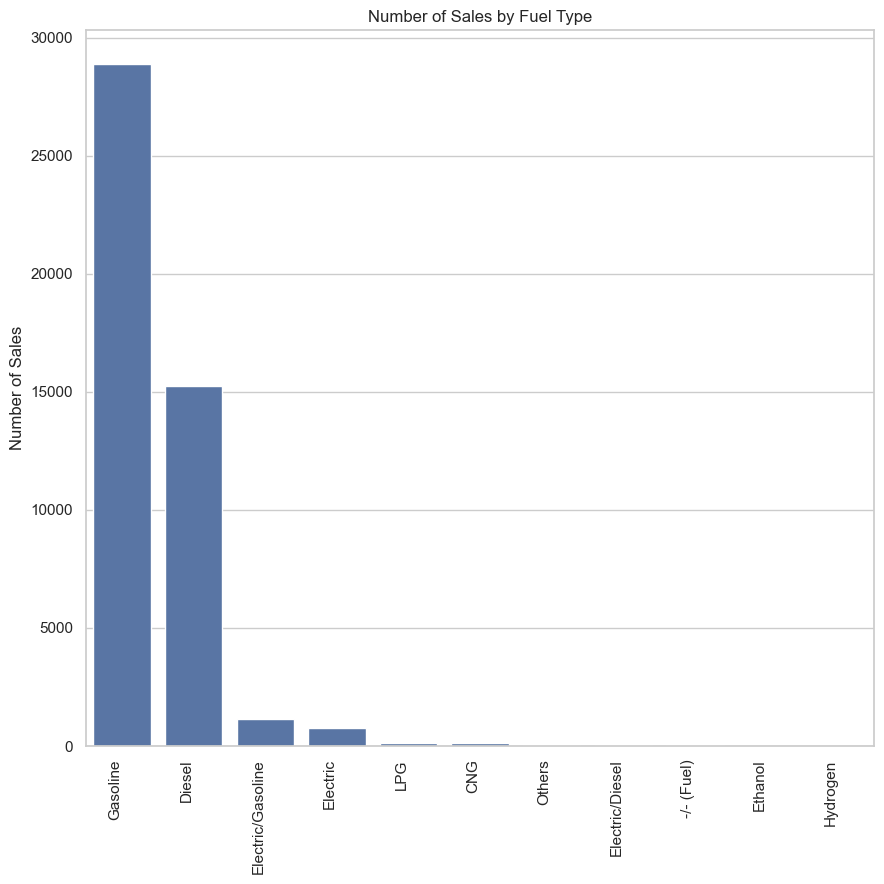

In [72]:
# Set the style for seaborn
sns.set_theme(style="whitegrid")

# Set up the matplotlib figure for each variable
plt.figure(figsize=(9, 9))

# Create a barplot for the current variable
sns.barplot(x='Level', y='Count', data=counts_df[counts_df['Variable'] == 'fuel'])
# Customize the plot
plt.title(f'Number of Sales by Fuel Type')
plt.xlabel('')
plt.ylabel('Number of Sales')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, ha='right')

# Show the plot for the current variable
plt.savefig('../reports/figures/sales_by_fuel.png')
plt.tight_layout()
plt.show()

Gasoline and diesel are the most widely used types of fuel, while all other types of fuel account for a relatively insignificant share of sales volumes.

Plot number of sales by gear type.

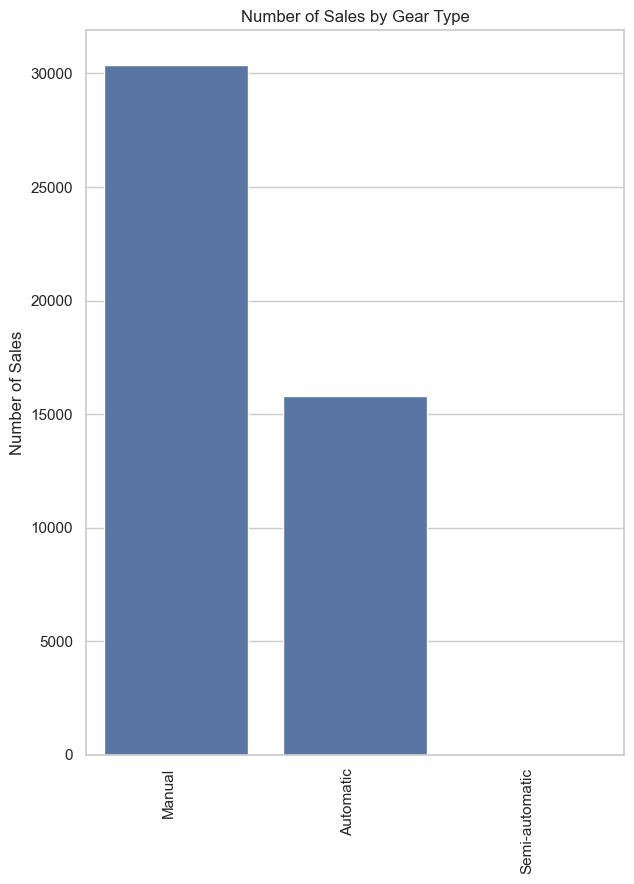

In [77]:
# Set the style for seaborn
sns.set_theme(style="whitegrid")

# Set up the matplotlib figure for each variable
plt.figure(figsize=(6.5, 9))

# Create a barplot for the current variable
sns.barplot(x='Level', y='Count', data=counts_df[counts_df['Variable'] == 'gear'])
# Customize the plot
plt.title(f'Number of Sales by Gear Type')
plt.xlabel('')
plt.ylabel('Number of Sales')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, ha='right')

# Show the plot for the current variable
plt.savefig('../reports/figures/sales_by_gear.png')
plt.tight_layout()
plt.show()

Manual and automatic are the most widely used gear types, while semi-automatic accounts for a relatively insignificant share of sales volumes.

Plot number of sales by offer type.

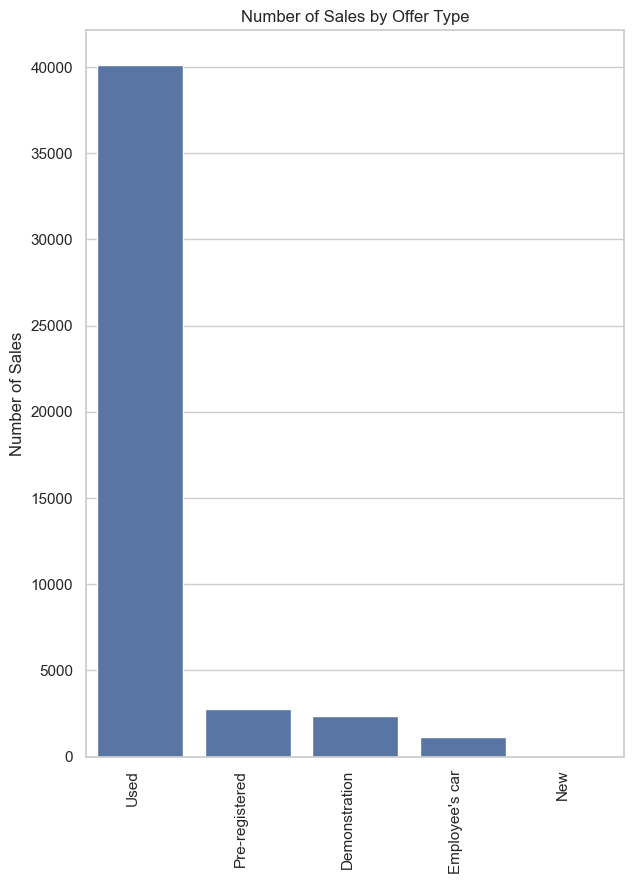

In [78]:
# Set the style for seaborn
sns.set_theme(style="whitegrid")

# Set up the matplotlib figure for each variable
plt.figure(figsize=(6.5, 9))

# Create a barplot for the current variable
sns.barplot(x='Level', y='Count', data=counts_df[counts_df['Variable'] == 'offerType'])
# Customize the plot
plt.title(f'Number of Sales by Offer Type')
plt.xlabel('')
plt.ylabel('Number of Sales')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, ha='right')

# Show the plot for the current variable
plt.savefig('../reports/figures/sales_by_offertype.png')
plt.tight_layout()
plt.show()

Used cars dominate sales by a significant margin, while sales of other offer types are comparatively minor.

### 2.3.2. Target distribution by categorical levels

Visualize the mean price (+- standard deviation) across the levels of each categorical variable.

Plot prices by car makes.

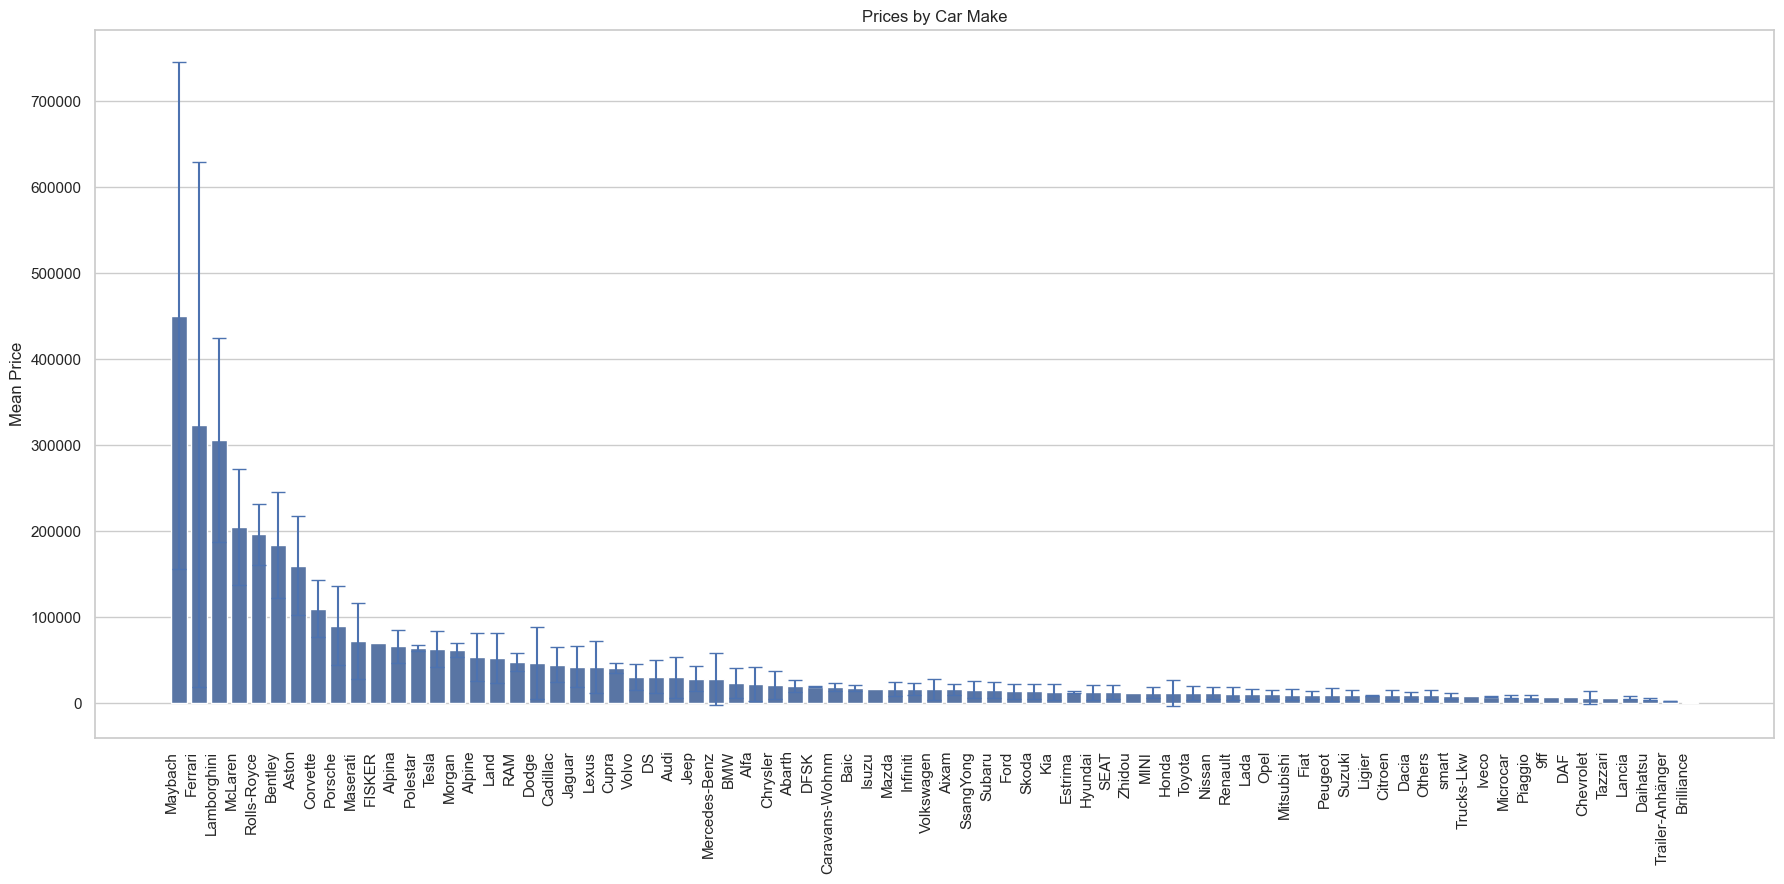

In [126]:
make_mean_price = df_raw.groupby("make")['price'].mean()
make_std_price = df_raw.groupby("make")['price'].std()

# Combine mean price and standard deviation into a DataFrame
make_price_stats = pd.concat([make_mean_price, make_std_price], axis=1)
make_price_stats.columns = ['Mean Price', 'Standard Deviation']

# Sort DataFrame by mean price in descending order
make_price_stats = make_price_stats.sort_values(by='Mean Price', ascending=False)

# Set up the matplotlib figure
plt.figure(figsize=(18, 9))

# Create a barplot for mean price
sns.barplot(x=make_price_stats.index, y=make_price_stats['Mean Price'])

# Plot error bars for standard deviation
plt.errorbar(x=make_price_stats.index, y=make_price_stats['Mean Price'], yerr=make_price_stats['Standard Deviation'], fmt='none', capsize=5)

# Customize the plot    
plt.xlabel('')
plt.title(f'Prices by Car Make')
plt.ylabel('Mean Price')
plt.xticks(rotation=90, ha='right')

# Show the plot for the current variable
plt.savefig('../reports/figures/prices_by_make.png')
plt.tight_layout()
plt.show()

The first nine makes exhibit significantly higher prices than others, with a rapid price decline during this section. Subsequently, the price decline becomes more gradual.

Plot prices by car models.

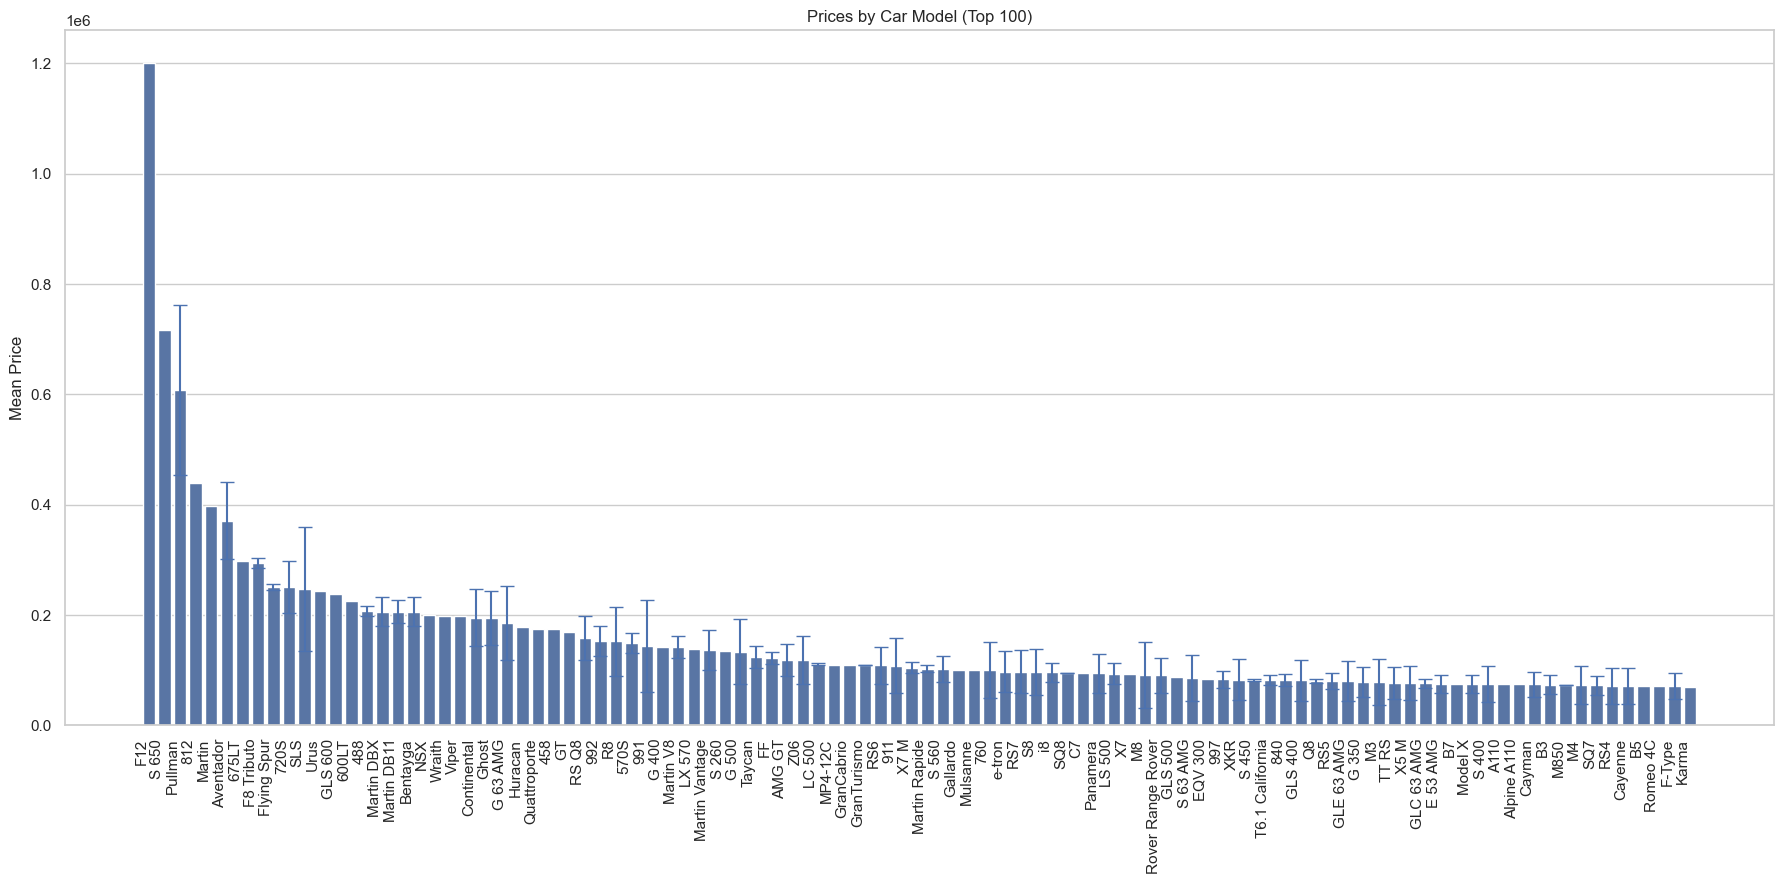

In [127]:
# Calculate mean price and standard deviation for each model
model_mean_price = df_raw.groupby("model")['price'].mean()
model_std_price = df_raw.groupby("model")['price'].std()

# Combine mean price and standard deviation into a DataFrame
model_price_stats = pd.concat([model_mean_price, model_std_price], axis=1)
model_price_stats.columns = ['Mean Price', 'Standard Deviation']

# Sort DataFrame by mean price in descending order
model_price_stats = model_price_stats.sort_values(by='Mean Price', ascending=False).head(100)

# Set up the matplotlib figure
plt.figure(figsize=(18, 9))

# Create a barplot for mean price
sns.barplot(x=model_price_stats.index, y=model_price_stats['Mean Price'])

# Plot error bars for standard deviation
plt.errorbar(x=model_price_stats.index, y=model_price_stats['Mean Price'], yerr=model_price_stats['Standard Deviation'], fmt='none', capsize=5)

# Customize the plot    
plt.xlabel('')
plt.ylabel('Mean Price')
plt.title(f'Prices by Car Model (Top 100)')
plt.xticks(rotation=90, ha='right')

# Show the plot for the current variable
plt.savefig('../reports/figures/prices_by_model.png')
plt.tight_layout()
plt.show()


The first six models exhibit significantly higher prices than others, with a rapid price decline during this section. Subsequently, the price decline becomes more gradual.

Plot prices by fuel types.

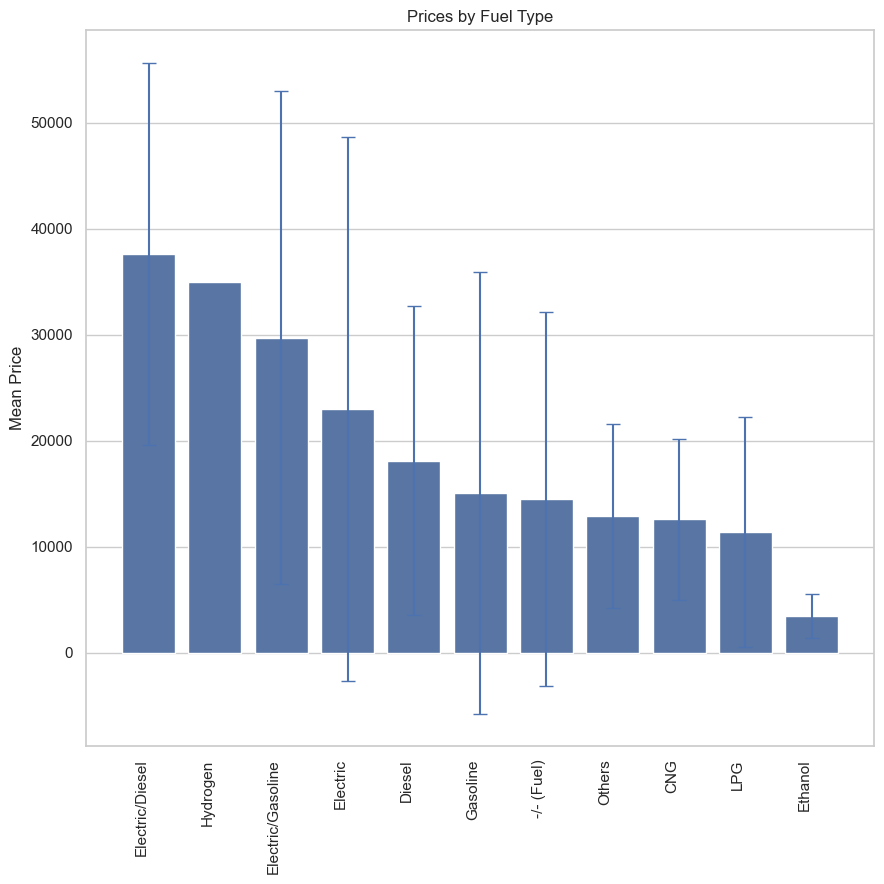

In [128]:
# Calculate mean price and standard deviation for each fuel type
fuel_mean_price = df_raw.groupby("fuel")['price'].mean()
fuel_std_price = df_raw.groupby("fuel")['price'].std()

# Combine mean price and standard deviation into a DataFrame
fuel_price_stats = pd.concat([fuel_mean_price, fuel_std_price], axis=1)
fuel_price_stats.columns = ['Mean Price', 'Standard Deviation']

# Sort DataFrame by mean price in descending order
fuel_price_stats = fuel_price_stats.sort_values(by='Mean Price', ascending=False)

# Set up the matplotlib figure
plt.figure(figsize=(9, 9))

# Create a barplot for mean price
sns.barplot(x=fuel_price_stats.index, y=fuel_price_stats['Mean Price'])

# Plot error bars for standard deviation
plt.errorbar(x=fuel_price_stats.index, y=fuel_price_stats['Mean Price'], yerr=fuel_price_stats['Standard Deviation'], fmt='none', capsize=5)

# Customize the plot    
plt.xlabel('')
plt.title(f'Prices by Fuel Type')
plt.ylabel('Mean Price')
plt.xticks(rotation=90, ha='right')

# Show the plot for the current variable
plt.savefig('../reports/figures/prices_by_fuel.png')
plt.tight_layout()
plt.show()


The prices of fuel types exhibit a consistent decline. Nonetheless, ethanol fuel stands out as notably cheaper compared to other fuel types.

Plot prices by gear types.

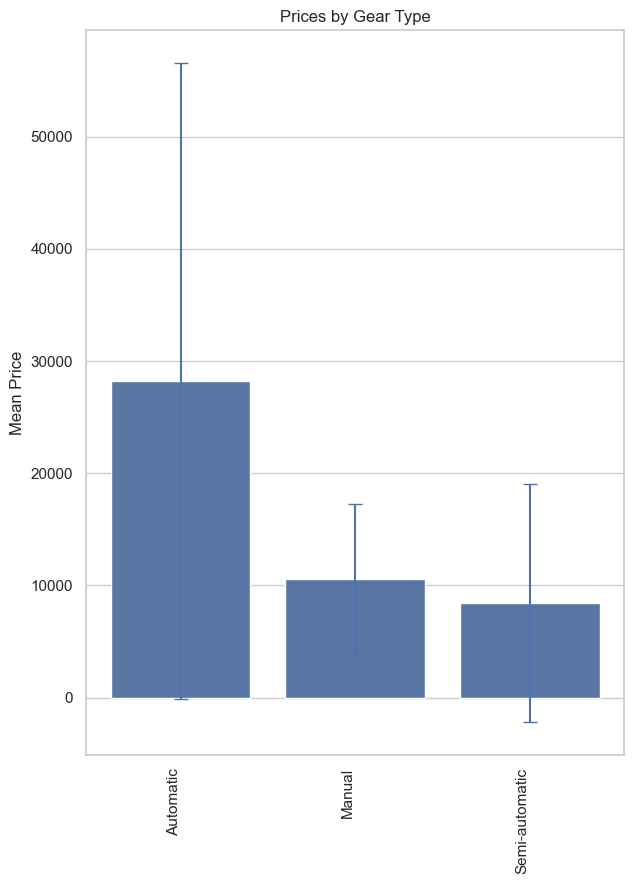

In [129]:
# Calculate mean price and standard deviation for each gear type
gear_mean_price = df_raw.groupby("gear")['price'].mean()
gear_std_price = df_raw.groupby("gear")['price'].std()

# Combine mean price and standard deviation into a DataFrame
gear_price_stats = pd.concat([gear_mean_price, gear_std_price], axis=1)
gear_price_stats.columns = ['Mean Price', 'Standard Deviation']

# Sort DataFrame by mean price in descending order
gear_price_stats = gear_price_stats.sort_values(by='Mean Price', ascending=False)

# Set up the matplotlib figure
plt.figure(figsize=(6.5, 9))

# Create a barplot for mean price
sns.barplot(x=gear_price_stats.index, y=gear_price_stats['Mean Price'])

# Plot error bars for standard deviation
plt.errorbar(x=gear_price_stats.index, y=gear_price_stats['Mean Price'], yerr=gear_price_stats['Standard Deviation'], fmt='none', capsize=5)

# Customize the plot    
plt.xlabel('')
plt.title(f'Prices by Gear Type')
plt.ylabel('Mean Price')
plt.xticks(rotation=90, ha='right')

# Show the plot for the current variable
plt.savefig('../reports/figures/prices_by_gear.png')
plt.tight_layout()
plt.show()


The price for cars with automatic gear is almost three times higher compared to manual and semi-automatic.

Plot prices by offer types.

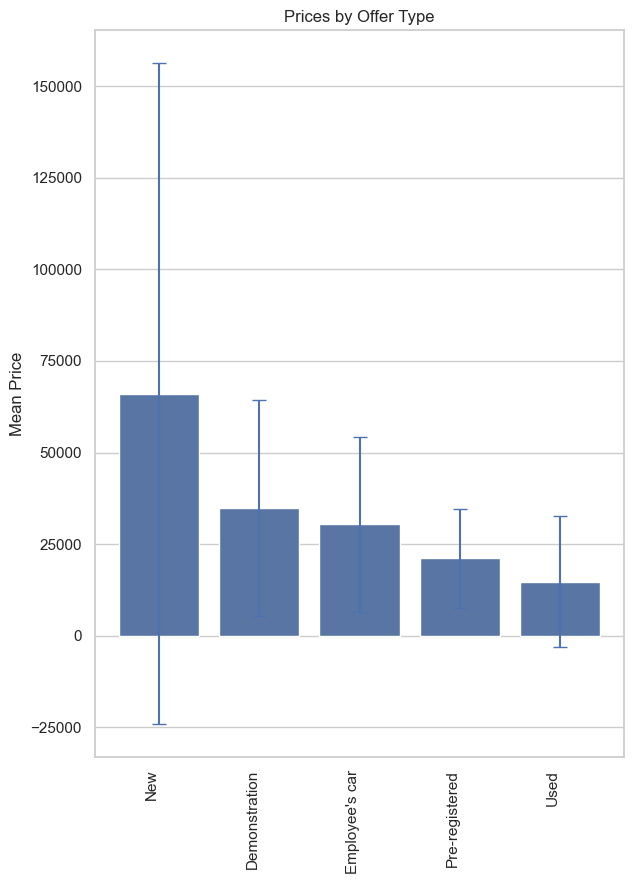

In [130]:
# Calculate mean price and standard deviation for each offer type
offer_type_mean_price = df_raw.groupby("offerType")['price'].mean()
offer_type_std_price = df_raw.groupby("offerType")['price'].std()

# Combine mean price and standard deviation into a DataFrame
offer_type_price_stats = pd.concat([offer_type_mean_price, offer_type_std_price], axis=1)
offer_type_price_stats.columns = ['Mean Price', 'Standard Deviation']

# Sort DataFrame by mean price in descending order
offer_type_price_stats = offer_type_price_stats.sort_values(by='Mean Price', ascending=False)

# Set up the matplotlib figure
plt.figure(figsize=(6.5, 9))

# Create a barplot for mean price
sns.barplot(x=offer_type_price_stats.index, y=offer_type_price_stats['Mean Price'])

# Plot error bars for standard deviation
plt.errorbar(x=offer_type_price_stats.index, y=offer_type_price_stats['Mean Price'], yerr=offer_type_price_stats['Standard Deviation'], fmt='none', capsize=5)

# Customize the plot    
plt.xlabel('')
plt.title(f'Prices by Offer Type')
plt.ylabel('Mean Price')
plt.xticks(rotation=90, ha='right')

# Show the plot for the current variable
plt.savefig('../reports/figures/prices_by_offertype.png')
plt.tight_layout()
plt.show()


New cars are priced significantly higher than other offer types, while used cars are the most affordable.

## 2.4. Continuous Variables

### 2.4.1. Correlation

A correlation analysis is carried out for numerical variables, including the target variable "price" and the features "mileage", "hp" and "year". The results are visualized by a heat map showing both Pearson and Spearman correlation coefficients. The Pearson correlation highlights linear relationships between numerical variables, while the Spearman correlation captures any form of relationships through the rank correlation.

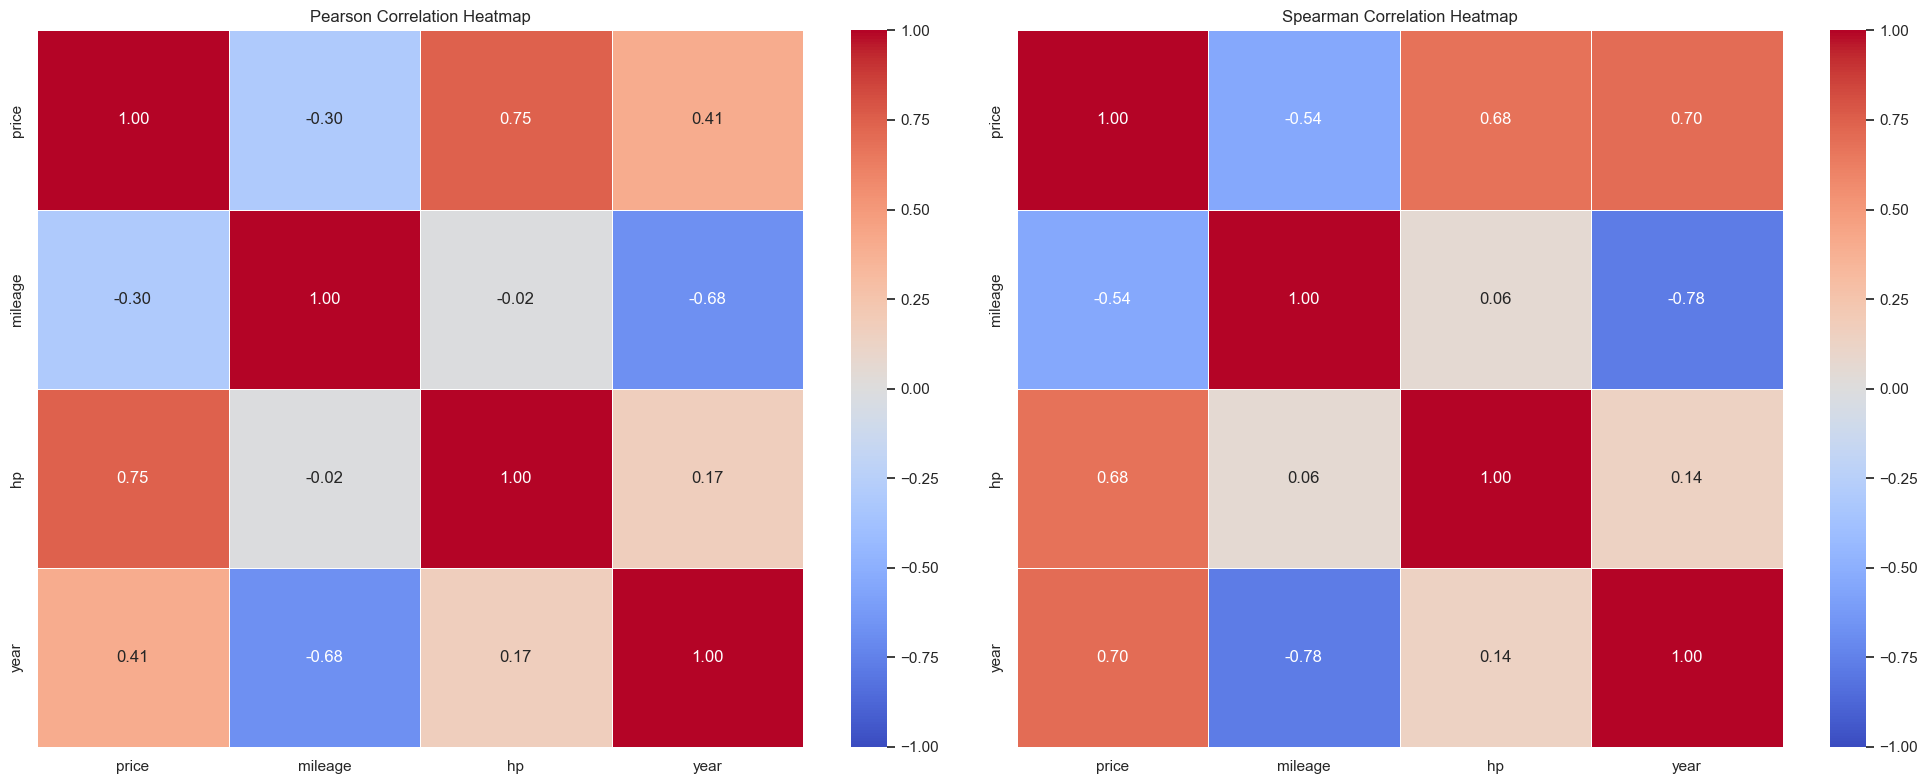

In [134]:
# Select the numerical variables
numerical_columns = ['price', 'mileage', 'hp', 'year']

# Create a correlation matrix including numerical and ordinal variables
pearson_correlation_matrix = df_raw[numerical_columns].corr(method='pearson')
spearman_correlation_matrix = df_raw[numerical_columns].corr(method='spearman')

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Create heatmaps using seaborn for Pearson and Spearman correlations
sns.heatmap(pearson_correlation_matrix, ax=axes[0], annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, vmin=-1, vmax=1)
sns.heatmap(spearman_correlation_matrix, ax=axes[1], annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, vmin=-1, vmax=1)

# Set titles for each plot
axes[0].set_title('Pearson Correlation Heatmap')
axes[1].set_title('Spearman Correlation Heatmap')

# Show the plot
plt.savefig('../reports/figures/correlation_heatmaps.png')
plt.tight_layout()
plt.show()

There exists a strong negative Pearson correlation between year and mileage, a moderately strong negative Pearson correlation between price and mileage, a significant positive Pearson correlation between price and horsepower (hp), and a moderately strong positive Pearson correlation between year and price. Overall, these patterns persist in the Spearman correlation analysis. However, certain variable pairings exhibit much stronger correlations, particularly between price and year, as well as price and mileage, indicating the potential benefit of variable transformations to enhance linearity among these variables.

### 2.4.2. Linearity

Create a grid of scatter plots to visualize the relationships between the target and the individual numeric features after applying various transformations to identify the transformations required to establish linearity between the target and the features.

Price vs. mileage

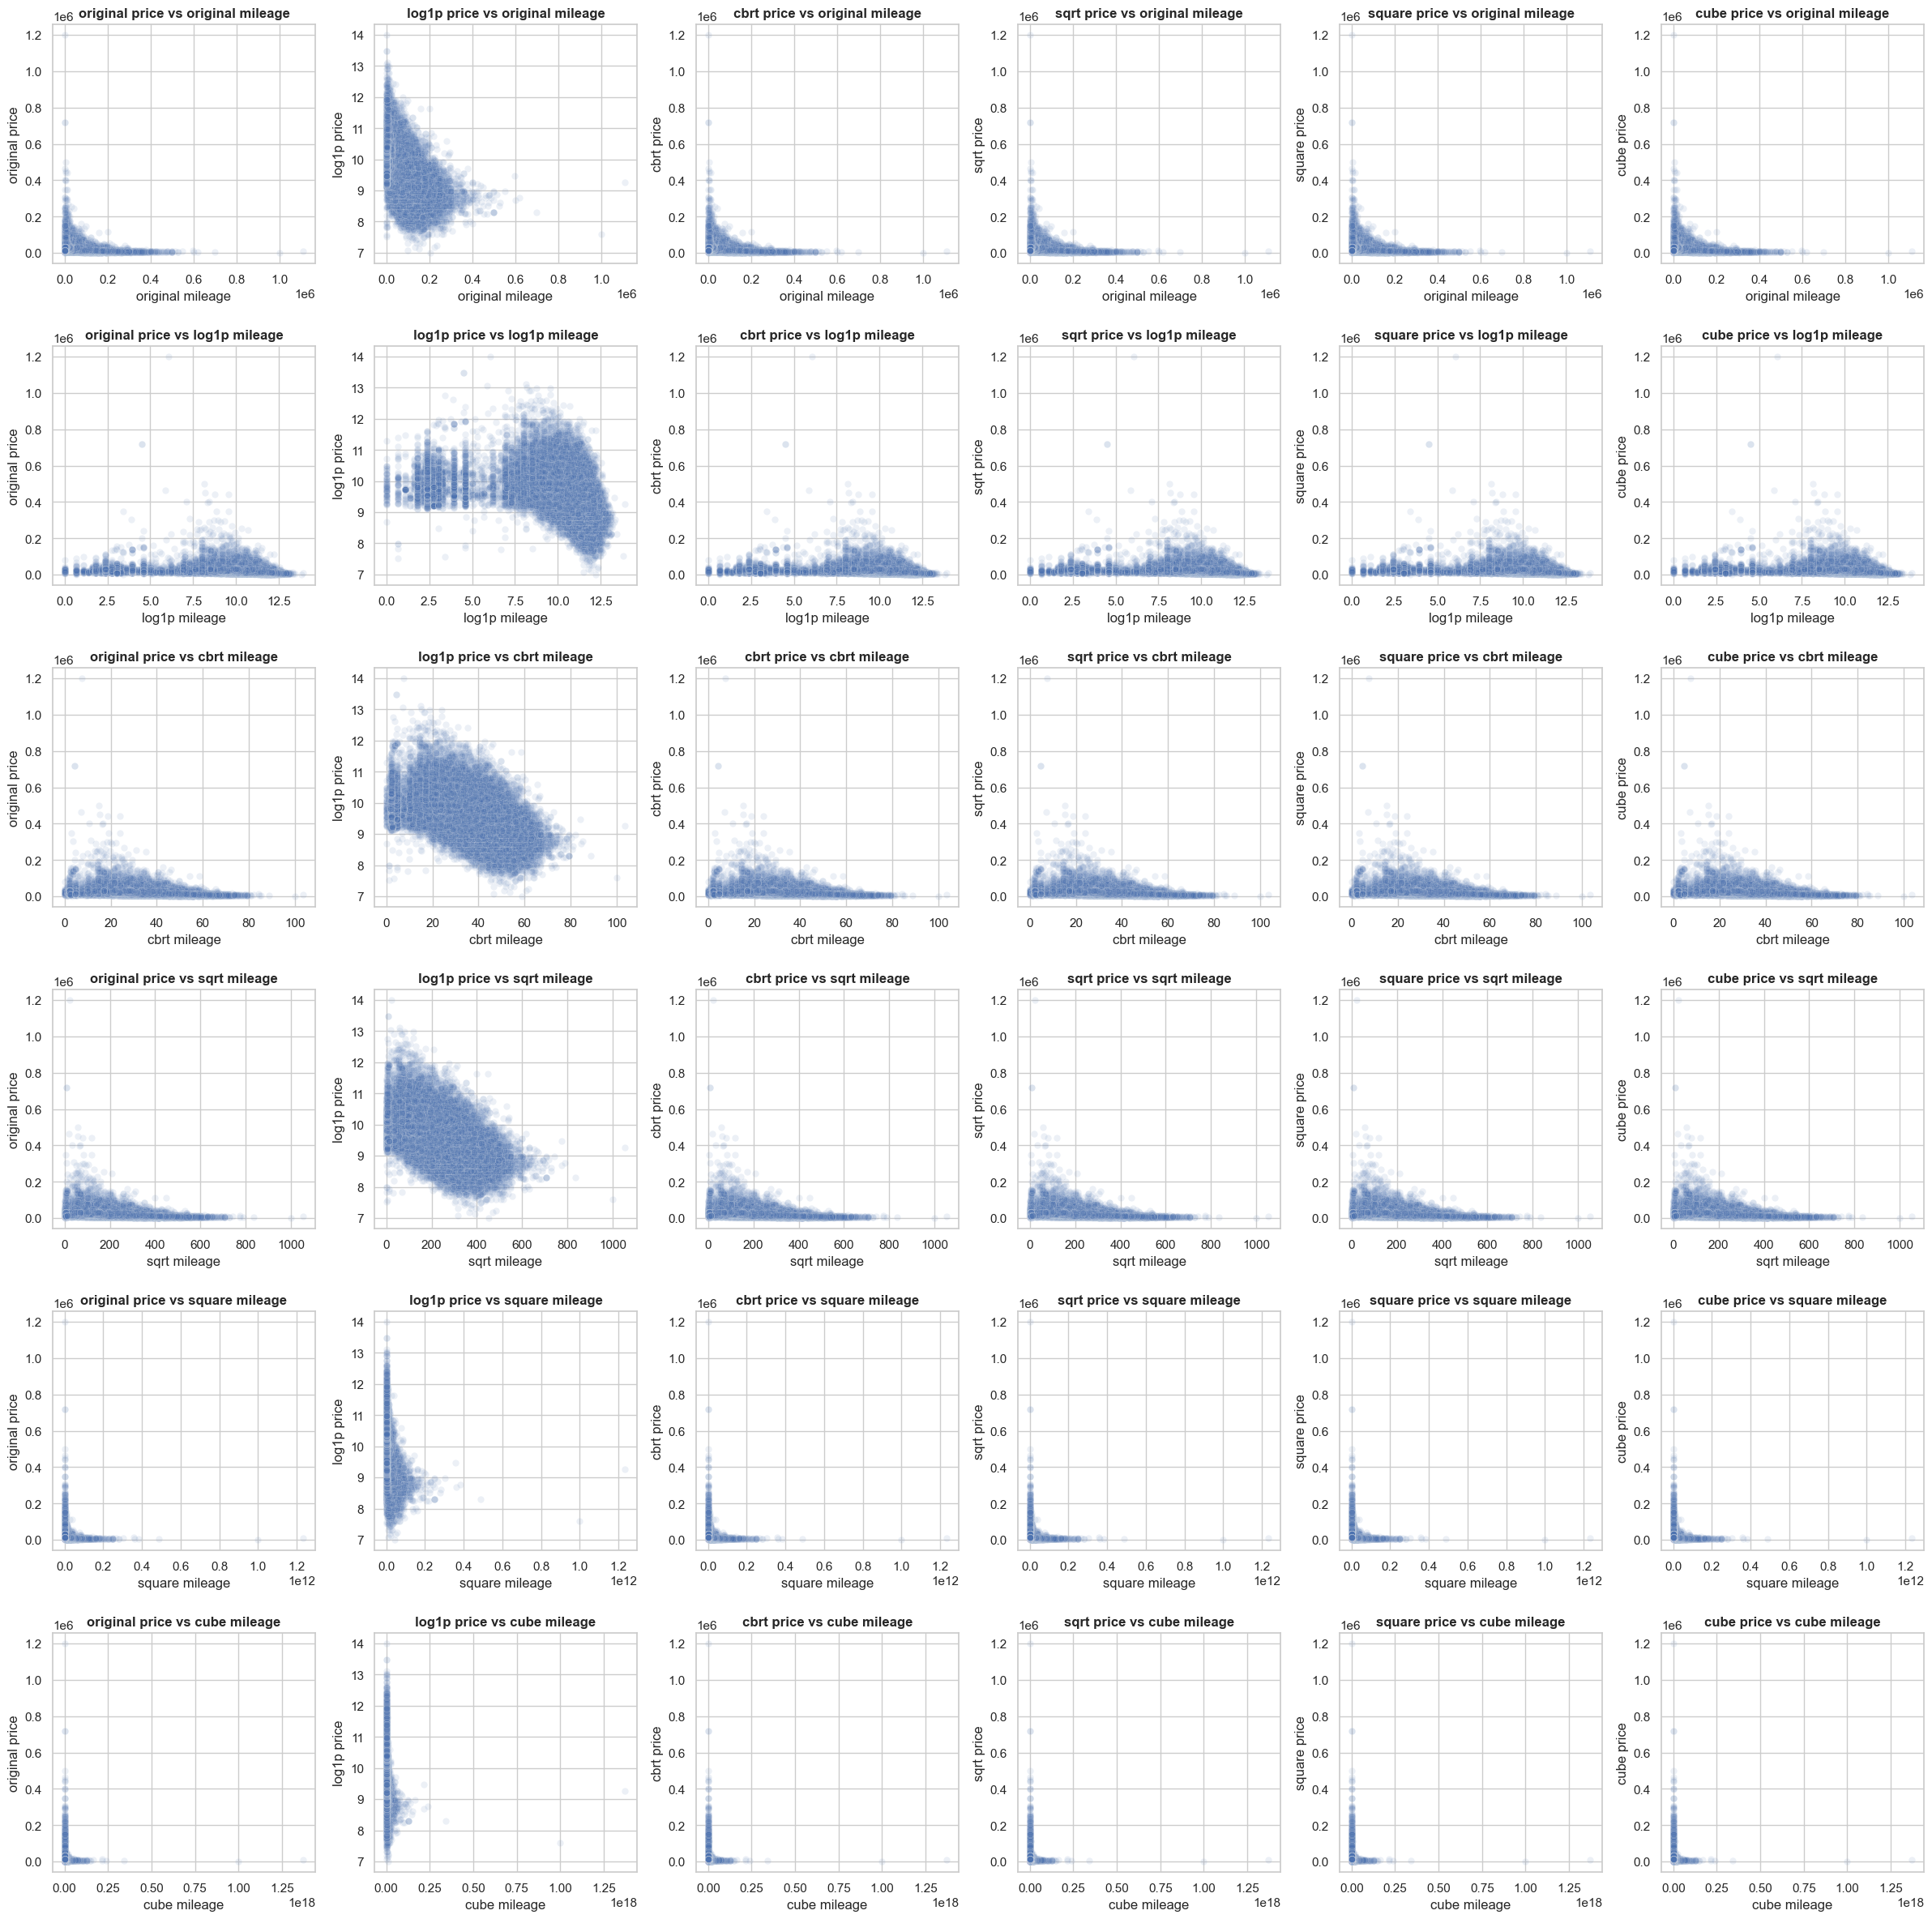

In [181]:
transformation_scatterplot_grid(df_raw, "mileage", "price")

A log1p transformation of the target in combination with a sqrt or cbrt transformation of the mileage seems suitable to achieve linearity.

Price vs. hp

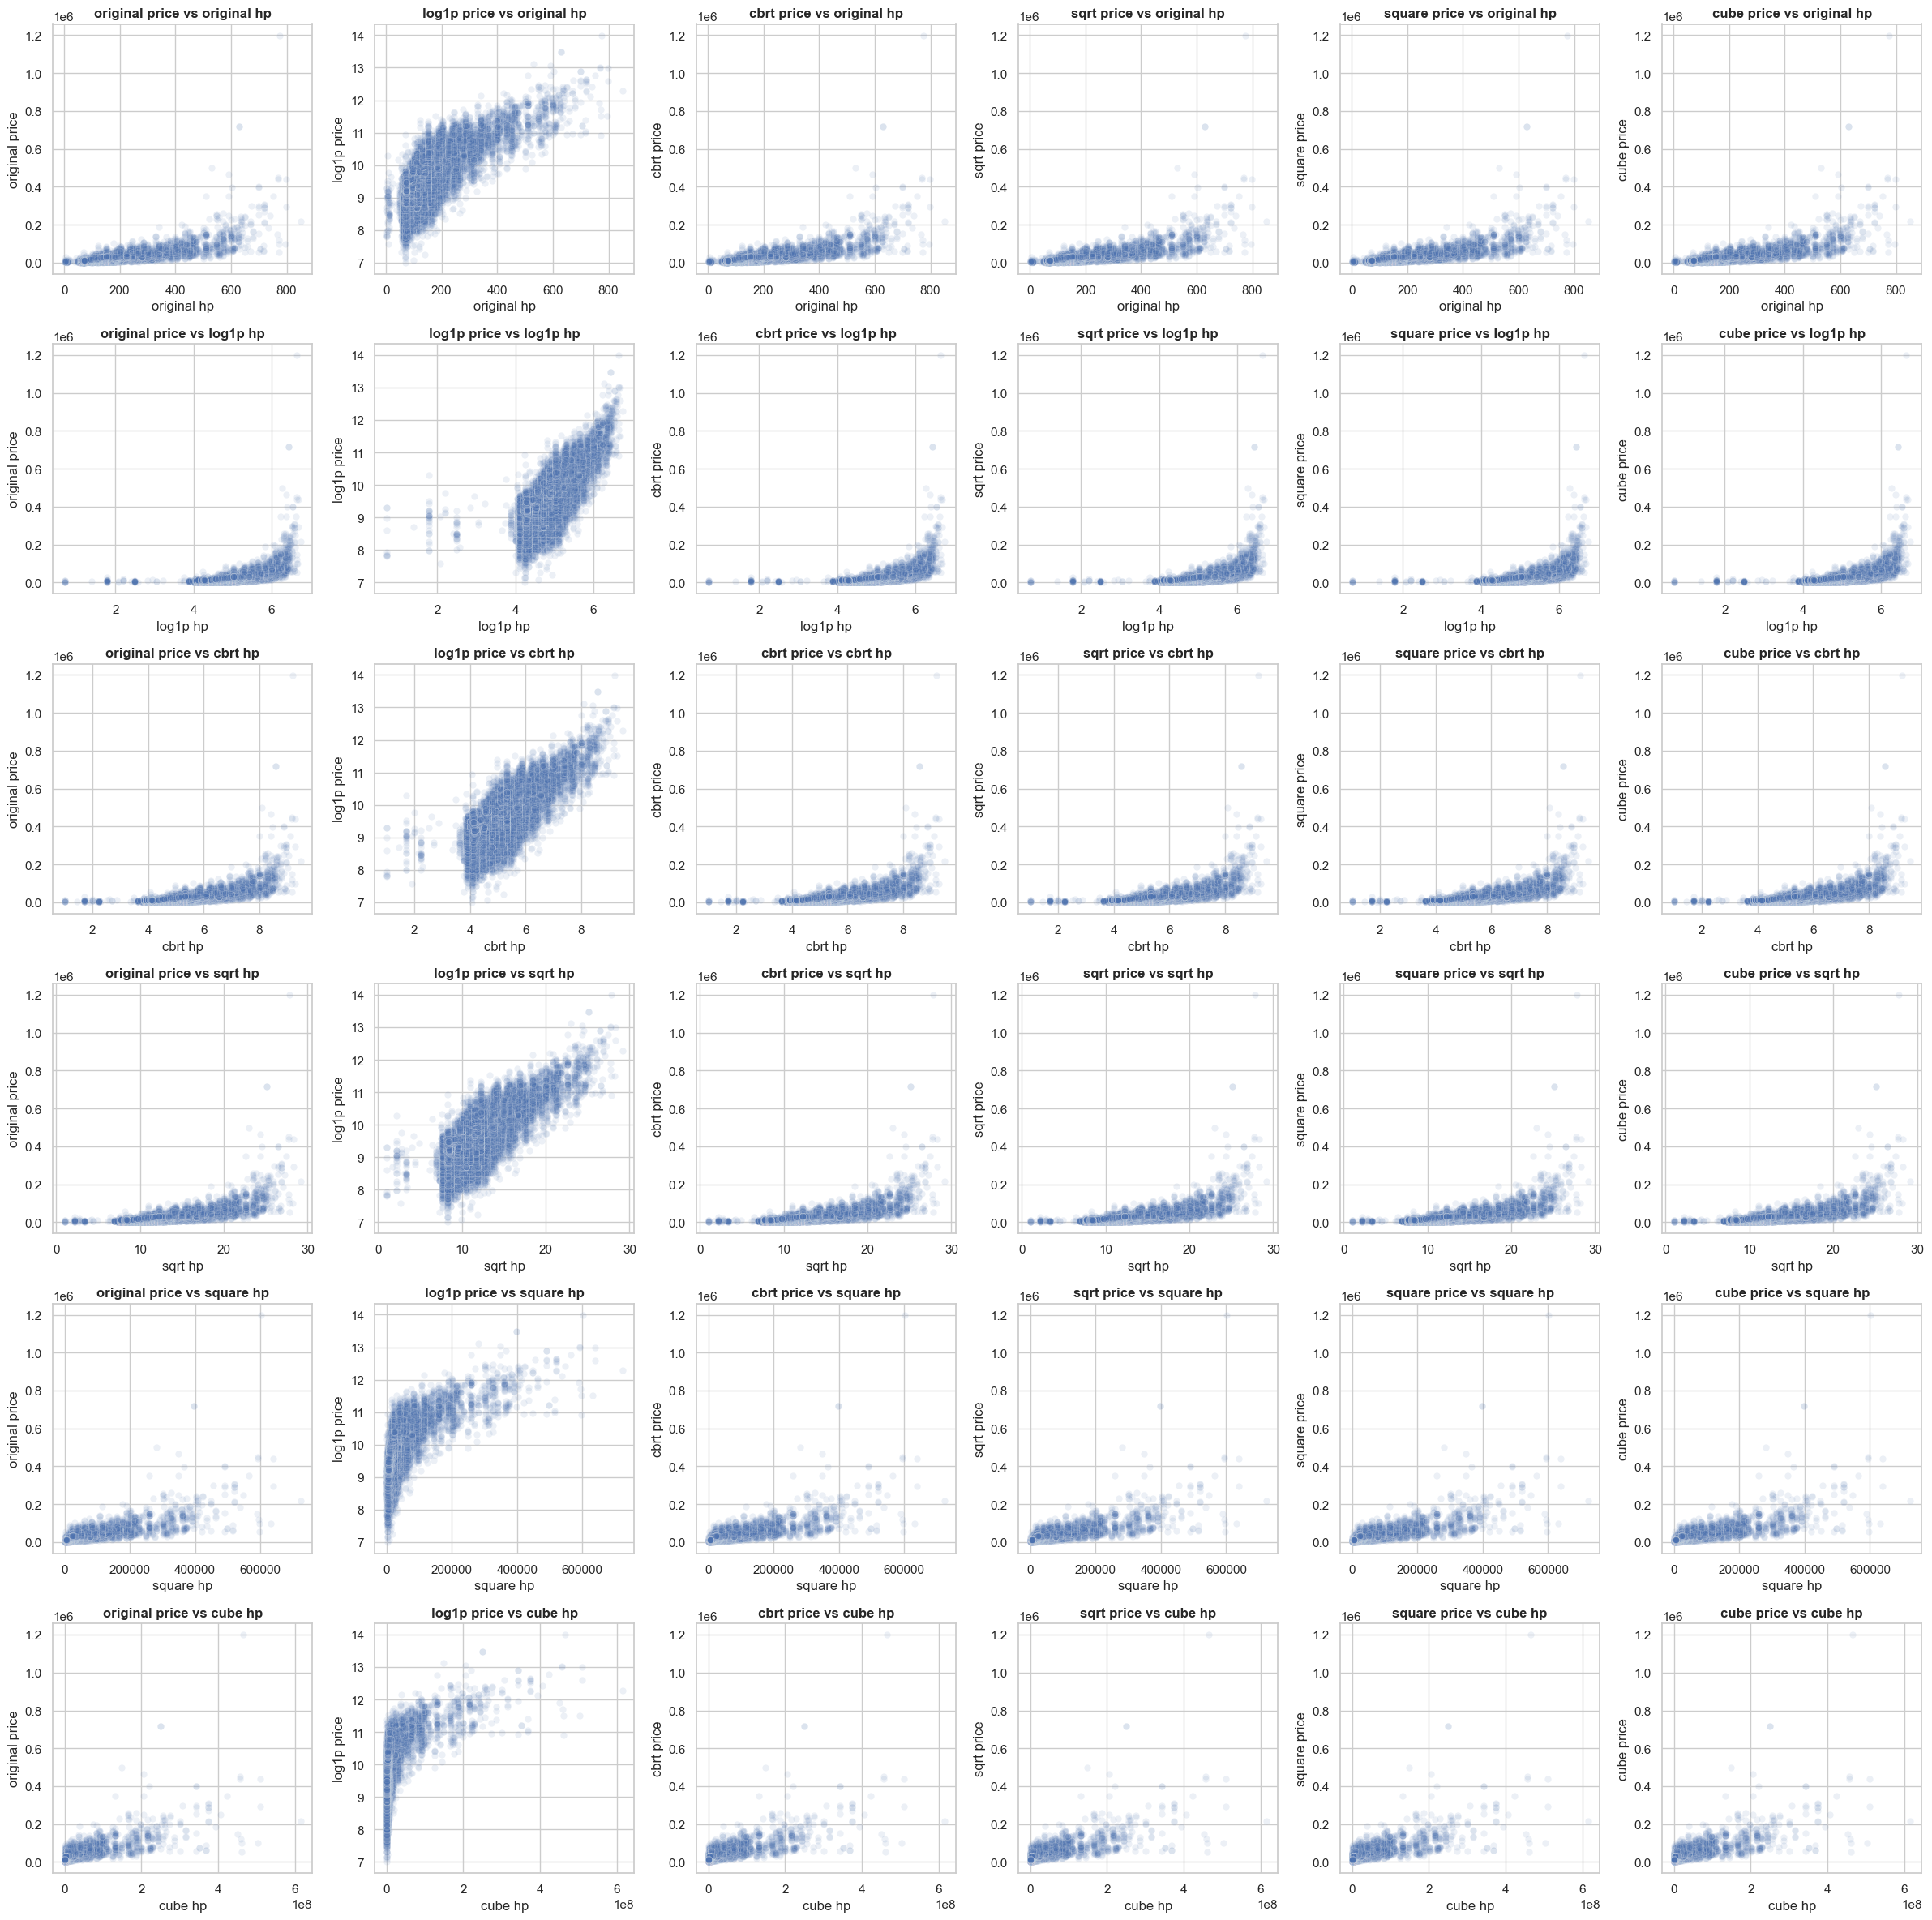

In [176]:
transformation_scatterplot_grid(df_raw, "hp", "price")

A log1p transformation of the target in combination with untransformed, sqrt or cbrt transformation of the hp seems suitable to achieve linearity.

Price vs. year

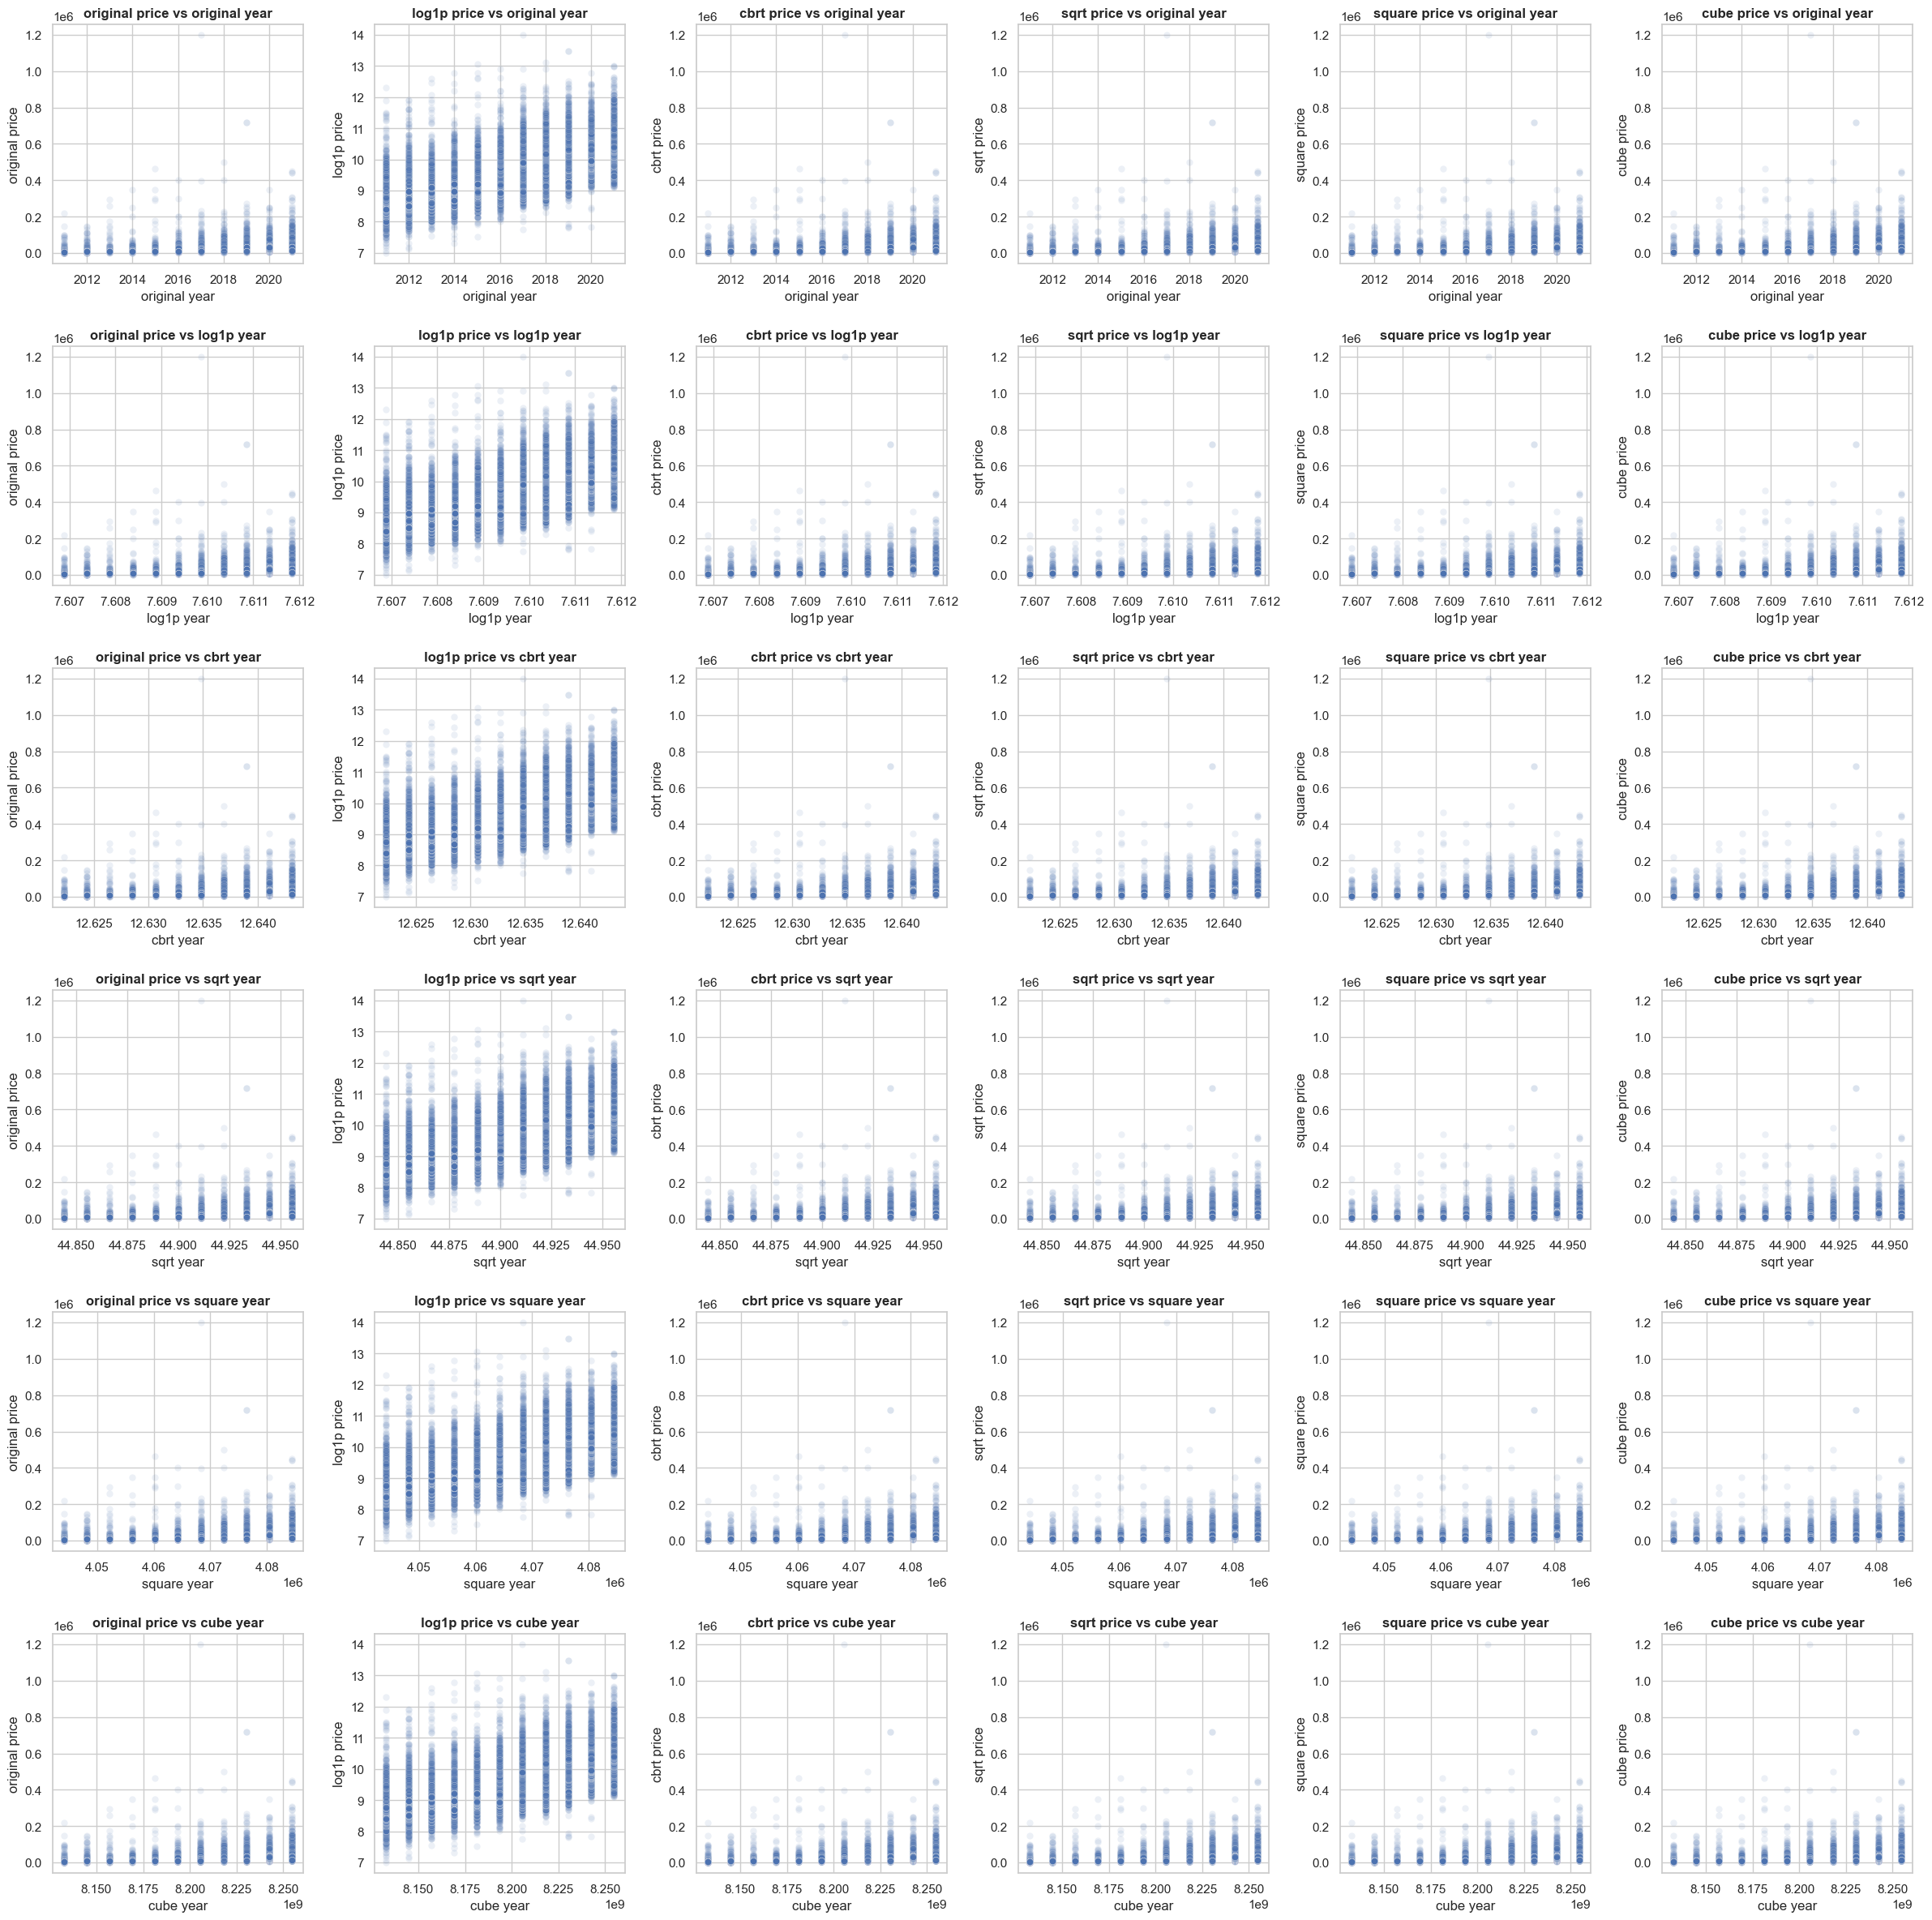

In [177]:
transformation_scatterplot_grid(df_raw, "year", "price")

A log1p transformation of the target in combination with an untransformed or any transformation of the year seems suitable to achieve linearity.

### 2.4.3. Distribution

### 2.4.4. Outliers